In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

В этом блокноте рассчитаем:
1. Средние координаты x и y для каждого зверька и части тела в каждую секунду
2. Для столбцов, обозначающих нахождение координат в интересующей зоне, сумма единиц / 25 (25 кадров в секунду)
3. Расстояние до центра банок от средней координаты

In [2]:
row_data = pd.read_csv('../3_output/row_data.csv', header = [0]).iloc[:, 1:]

1. Средняя координата (x и y) и доля времени, проведенная в зоне в конкретную секунду (сумма единиц / 25). Для (не)фильтрованных по likelihood данных

In [3]:
mean_cols = ["x", "y"]
sum_cols = [
    "border",
    "with_sorex_cup",
    "around_with_sorex",
    "empty_cup",
    "around_empty",
    "other",
]

not_filtered = (
    row_data.groupby(["ID", "bodyparts", "sec"])
    .agg(
        **{col: (col, lambda x: x.mean()) for col in mean_cols},  # средние координаты
        **{
            col: (col, lambda x: x.sum() / 25) for col in sum_cols
        }  # сумма единиц в столбце, поделенная на 25 (то есть доля времени, проведенной в эту секунду)
    )
    .reset_index()
)

filtered = (
    row_data.query('likelihood>0.6')
    .groupby(["ID", "bodyparts", "sec"])
    .agg(
        **{col: (col, lambda x: x.mean()) for col in mean_cols},  # средние координаты
        **{
            col: (col, lambda x: x.sum() / 25) for col in sum_cols
        }  # сумма единиц в столбце, поделенная на 25 (то есть доля времени, проведенной в эту секунду)
    )
    .reset_index()
)

2. Расчет расстояний до центра банок (предварительно обработаем, ведь зверьки сидели в разных банках)

In [4]:
center_coordinates = pd.read_csv('../3_output/coordinates/center_coord.csv').rename(columns = {'Image ID':'ID'})

In [5]:
# для этих двух зверьков зверьки сидели в левой банке
change_cup = center_coordinates.query(
    'ID == "Sar_84_13_07_24 00_00_10-00_05_10" | ID == "Sar_80_14_07_24 00_00_08-00_05_08"'
)


change_cup = change_cup.rename(
    columns={
        "XL": "with_sorex_X",
        "YL": "with_sorex_Y",
        "XR": "empty_X",
        "YR": "empty_Y"
    }
)


In [6]:
# для всеъ этих случаев зверьки сидели в правой банке
in_right = center_coordinates.query(
    'ID != "Sar_84_13_07_24 00_00_10-00_05_10" & ID != "Sar_80_14_07_24 00_00_08-00_05_08"'
)

in_right = in_right.rename(
    columns={
        "XR": "with_sorex_X",
        "YR": "with_sorex_Y",
        "XL": "empty_X",
        "YL": "empty_Y",
    }
)

center_coordinates = pd.concat([in_right, change_cup], axis=0, ignore_index=True)



# В ID зверька оставим только его номер и вид (для единообразия с ID в row_data)
center_coordinates['ID'] = center_coordinates['ID'].str.split('_').str[0:2].str.join('_')

In [7]:
# объединили координаты центров банок и исходный датасет (без фильтрации по Likelihood, координаты осреднены)
total_not_filtered = not_filtered.merge(center_coordinates, how="left", on="ID")

# и с фильтрацией по likelihood
total_filtered = filtered.merge(center_coordinates, how="left", on="ID")

In [8]:
# евклидово расстояние от точки в каждый момент времени до центра банок (нефильтрованные данные)
total_not_filtered["distance_from_sorex_cm"] =     round(np.sqrt(
        (total_not_filtered["x"] - total_not_filtered["with_sorex_X"]) ** 2 + 
        (total_not_filtered["y"] - total_not_filtered["with_sorex_Y"]) ** 2
        ) / 6, 2) # делим на 6, потому что в в 1 см 6 пикселей


total_not_filtered["distance_from_empty_cm"] = round(np.sqrt(
        (total_not_filtered["x"] - total_not_filtered["empty_X"]) ** 2 +
        (total_not_filtered["y"] - total_not_filtered["empty_Y"]) ** 2
        ) / 6, 2)

In [9]:
# евклидово расстояние от точки в каждый момент времени до центра банок (фильтрованные данные)
total_filtered["distance_from_sorex_cm"] =     round(np.sqrt(
        (total_filtered["x"] - total_filtered["with_sorex_X"]) ** 2 + 
        (total_filtered["y"] - total_filtered["with_sorex_Y"]) ** 2
        ) / 6, 2) # делим на 6, потому что в в 1 см 6 пикселей


total_filtered["distance_from_empty_cm"] = round(np.sqrt(
        (total_filtered["x"] - total_filtered["empty_X"]) ** 2 +
        (total_filtered["y"] - total_filtered["empty_Y"]) ** 2
        ) / 6, 2)

Итоговые датасеты: (не)фильтрованные по likelihood, рассчитаны расстояния до центра банок (со зверьком и без него)

In [10]:
total_not_filtered.drop(columns = ['empty_X', 'empty_Y', 'with_sorex_X', 'with_sorex_Y'], inplace = True)
total_filtered.drop(columns = ['empty_X', 'empty_Y', 'with_sorex_X', 'with_sorex_Y'], inplace = True)

Добавим к каждому столбец Spec

In [11]:
total_not_filtered['Spec'] = total_not_filtered['ID'].str.split('_').str[0]
total_filtered['Spec'] = total_not_filtered['ID'].str.split('_').str[0]

In [18]:
total_filtered['ID'].nunique()

31

In [16]:
total_not_filtered.to_csv('../3_output/not_filtered_with_distance.csv')
total_filtered.to_csv('../3_output/filtered_with_distance.csv')

Теперь попробуем сделать визуализацию распределений

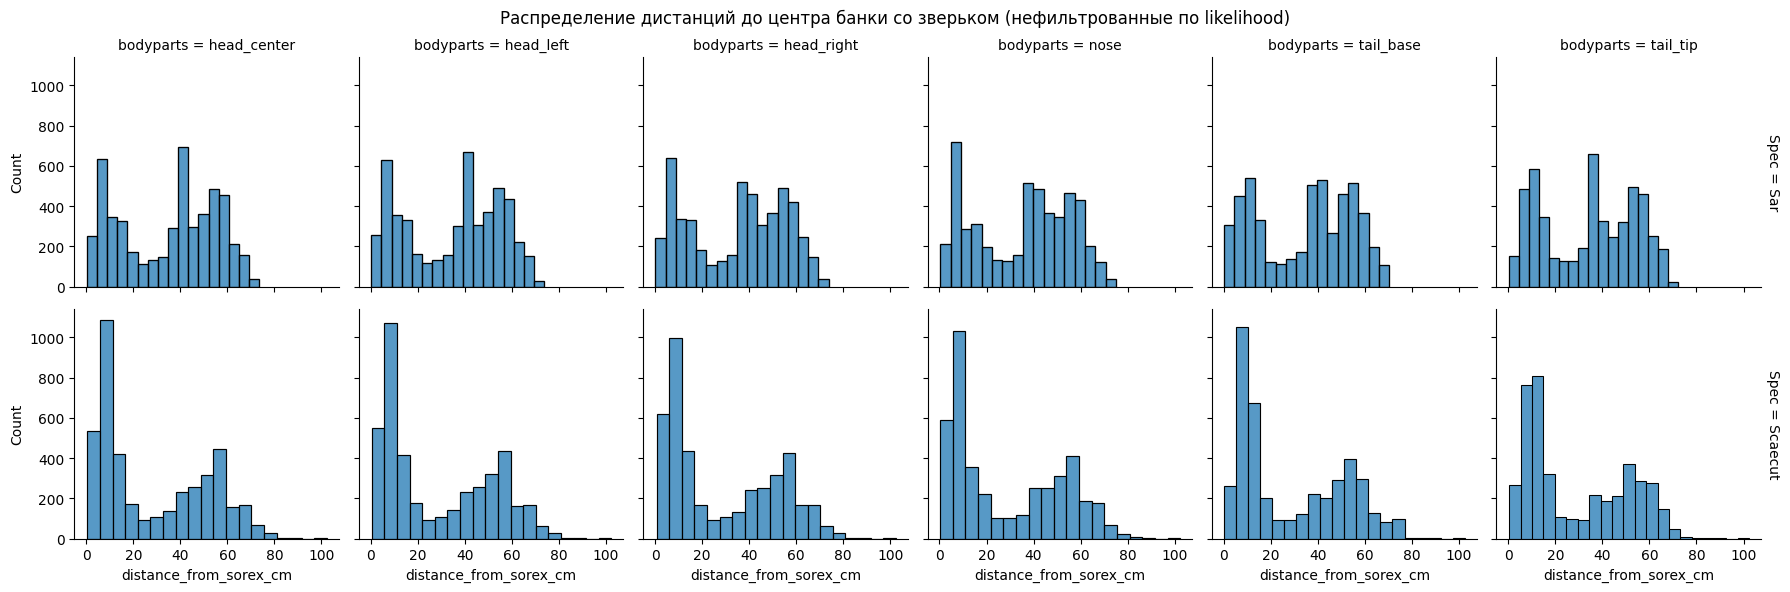

In [12]:
# расстояние до банки со зверьком (нефильтрованные данные)

g = sns.FacetGrid(total_not_filtered, col="bodyparts",  row="Spec", margin_titles=True)
g.map_dataframe(sns.histplot, x="distance_from_sorex_cm")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle('Распределение дистанций до центра банки со зверьком (нефильтрованные по likelihood)')

g.savefig('../3_output/distribution/distance_to_sorex(not_filtered).png')

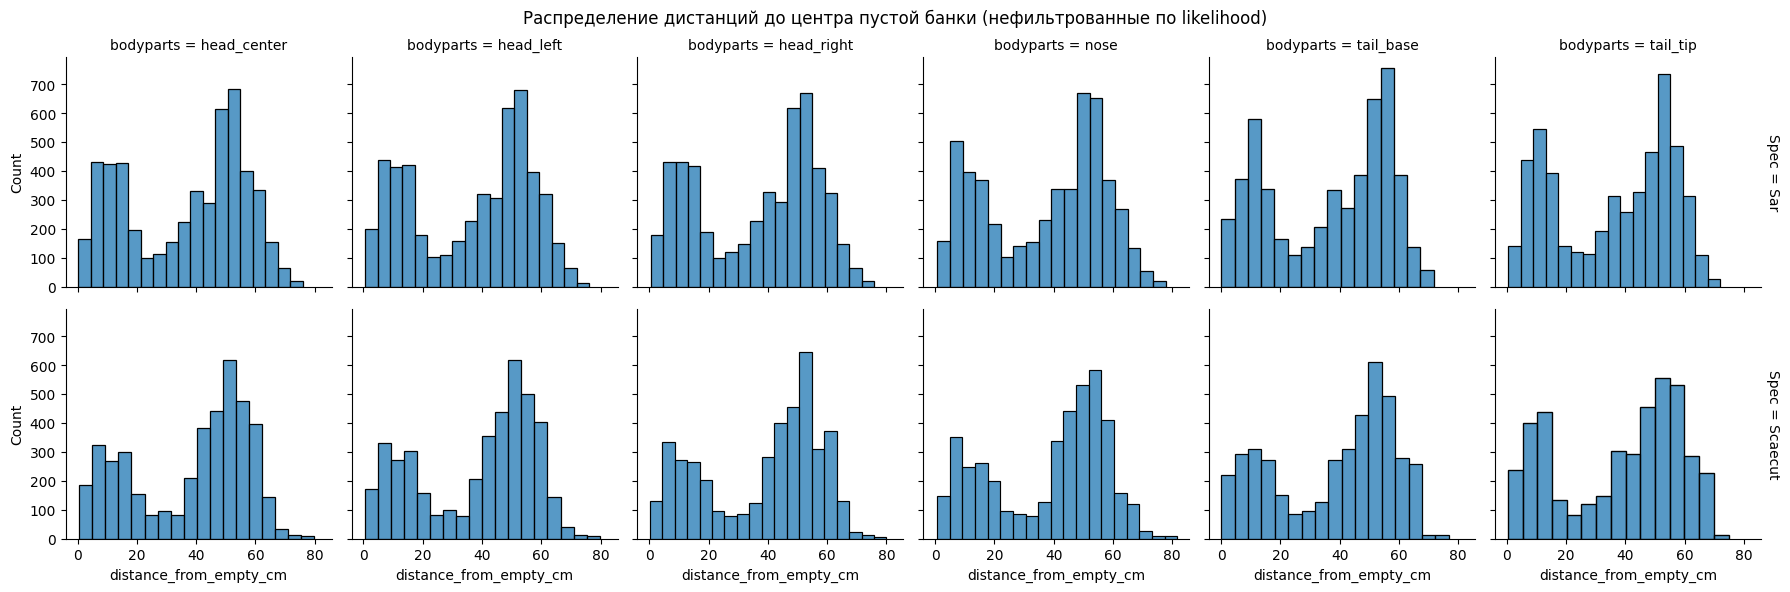

In [13]:
# расстояние до банки без зверька (нефильтрованные данные)

g = sns.FacetGrid(total_not_filtered, col="bodyparts",  row="Spec", margin_titles=True)
g.map_dataframe(sns.histplot, x="distance_from_empty_cm")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle('Распределение дистанций до центра пустой банки (нефильтрованные по likelihood)')

g.savefig('../3_output/distribution/distance_to_empty(not_filtered).png')

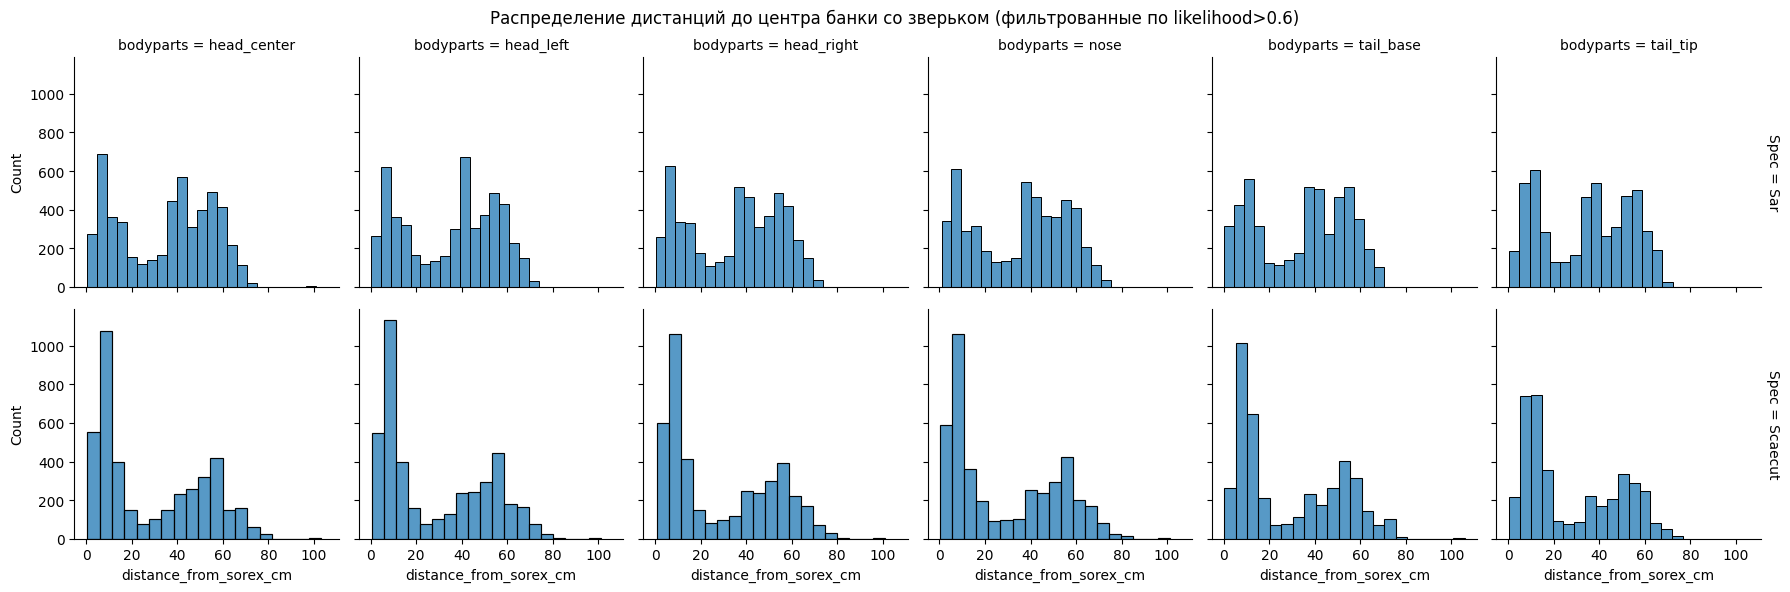

In [14]:
# расстояние до банки со зверьком (фильтрованные данные)

g = sns.FacetGrid(total_filtered, col="bodyparts",  row="Spec", margin_titles=True)
g.map_dataframe(sns.histplot, x="distance_from_sorex_cm")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle('Распределение дистанций до центра банки со зверьком (фильтрованные по likelihood>0.6)')

g.savefig('../3_output/distribution/distance_to_sorex(filtered).png')

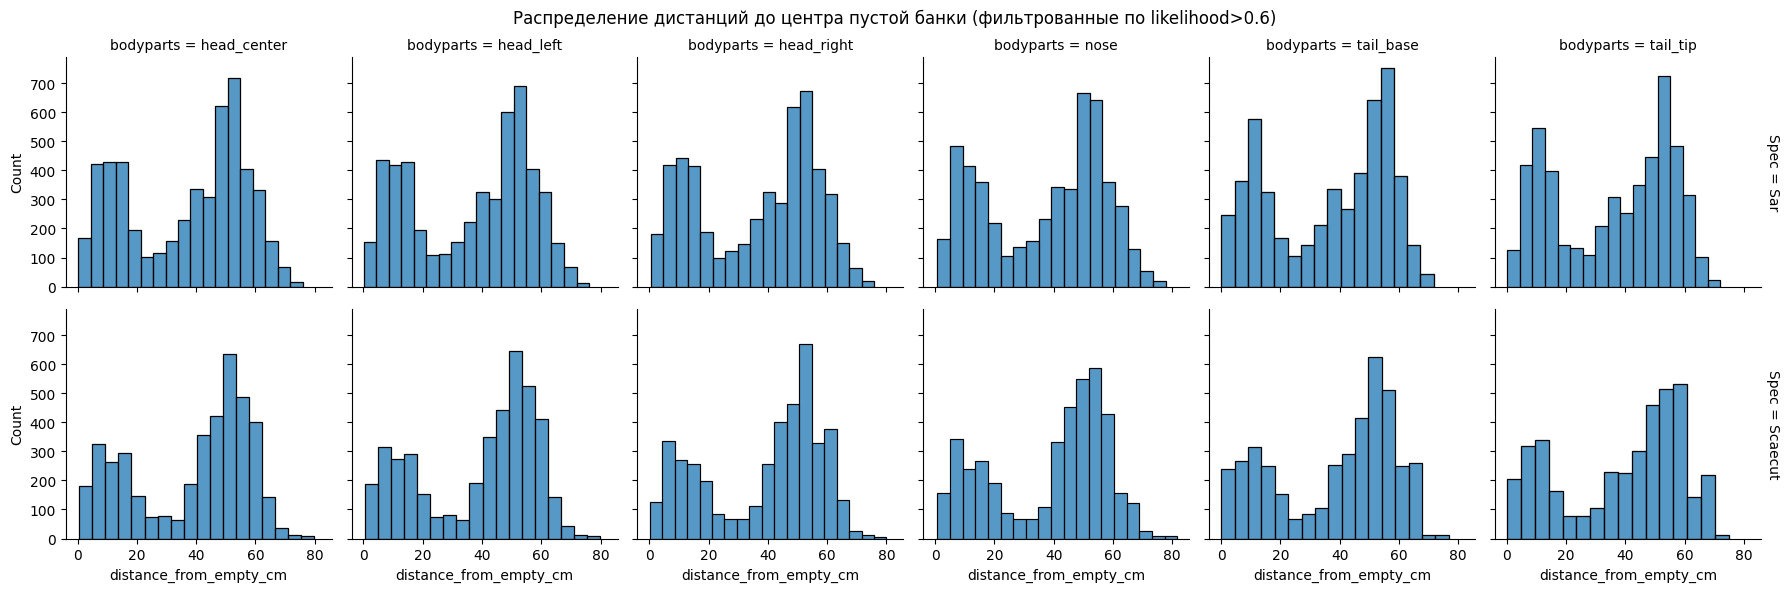

In [15]:
# расстояние до банки без зверька (фильтрованные данные)

g = sns.FacetGrid(total_filtered, col="bodyparts",  row="Spec", margin_titles=True)
g.map_dataframe(sns.histplot, x="distance_from_empty_cm")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle('Распределение дистанций до центра пустой банки (фильтрованные по likelihood>0.6)')

g.savefig('../3_output/distribution/distance_to_empty(filtered).png')